# Introduction

UNet has long been considered a traditional yet effective technique for image segmentation. However, with the rapid advancement of deep learning, many state-of-the-art segmentation methods have emerged in recent years. This raises an interesting question: is it possible to train a traditional UNet in such a way that it performs comparably to or even better than these newer methods? In this context, it becomes important to consider whether the choice of loss functions and fine-tuning strategies might play a more critical role than simply relying on a more sophisticated model architecture.

To address this question, we implemented a UNet model, then compared its performance with two state-of-the-art techniques: TransUNet and SwinUNETR. 

Our experiments were conducted using a dataset sourced from Kaggle, originally provided by The Cancer Imaging Archive (TCIA), consisting of brain MRI scans from 110 patients. Each patient has between 20 to 50 slices, totaling 3,929 brain images and corresponding masks, each with a resolution of 256×256 pixels.

# 1. Importing Necessary Libraries

In [ ]:
# import necessary libraries
import os
from glob import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# 2. Data Pre-Processing

All images are stored in TIF format, with each patient's data organized in a separate folder containing both brain images and their corresponding mask images. The mask images are easily identifiable by the inclusion of "_mask" in their filenames. 

To manage the data efficiently, we will create a DataFrame containing the file paths of each brain image and its corresponding mask. Using these paths, we will load the images as tensors. 

Since the brain images are in RGB, they are loaded as 3-channel tensors, while the masks, being grayscale, are loaded as single-channel tensors. During the loading process, we normalize the pixel values by dividing by 255, scaling them from a range of 0–255 to 0–1. For the mask images, we apply a binarization step where all pixel values greater than or equal to 0.5 are set to white, and the rest to black, to ensure clear and precise masking.

In [ ]:
# Create dataframe which stores path of every images and masks
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))
    df = pd.DataFrame(data= {'images': images_paths, 'masks': masks_paths})
    return df

data_dir = '../data/kaggle_3m'
df = create_df(data_dir)
df.head()

images  \
0  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...   
1  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...   
2  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...   
3  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...   
4  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...   

                                               masks  
0  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...  
1  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...  
2  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...  
3  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...  
4  ../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...

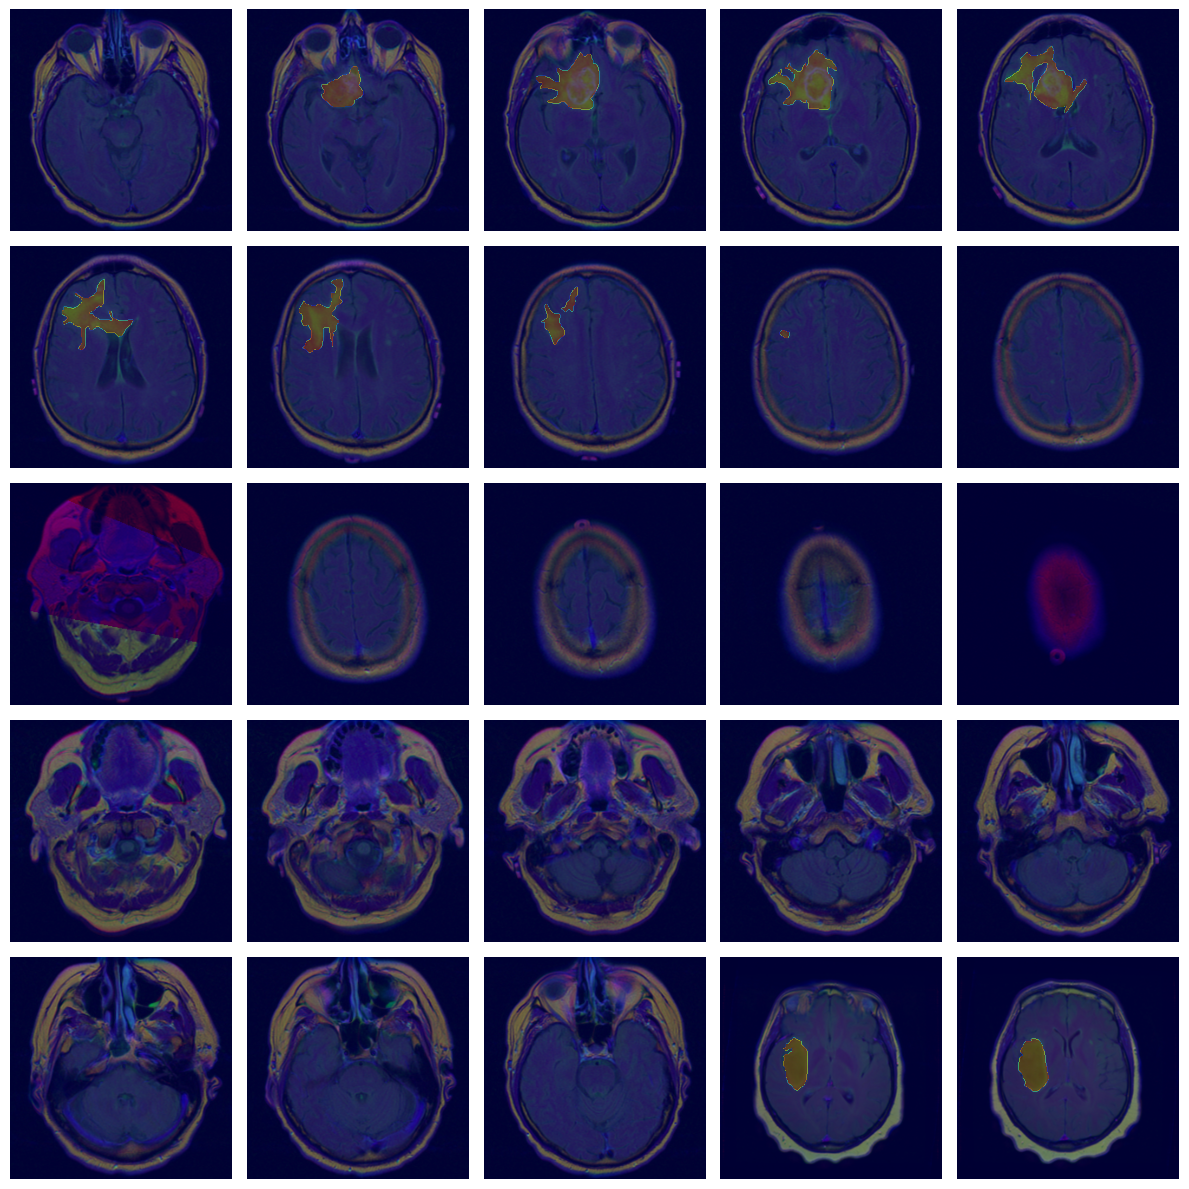

In [ ]:
# Load images to make sure they are properly showing
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)

        img_path = images[i]
        mask_path = masks[i]

        # Read and convert image to RGB
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Read the mask
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE) 

        # Display the image
        plt.imshow(image)
        plt.imshow(mask, cmap="jet", alpha=0.4) 
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images(list(df["images"]), list(df["masks"]))

In [ ]:
# Load images and masks to tensors and normalize (+ binarize)
class MaskBinarize:
    def __call__(self, msk):
        msk = (msk > 0.5).float()  
        return msk
    
def img_to_tensor(df, mask=False):
    if mask:
        transform = transforms.Compose([
            transforms.ToTensor(),          
            MaskBinarize()
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),          
            #MaskBinarize()
        ])
    
    image_tensors = []
    
    for img_path in df:
        try:
            if mask:
                img = Image.open(img_path).convert("L")  # grayscale transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
            else:
                img = Image.open(img_path).convert("RGB")  # RGB transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if image_tensors:
        # (batch, C, H, W)
        image_tensors = torch.stack(image_tensors)
        print(f"Loaded {len(image_tensors)} images successfully.")
        return image_tensors
    else:
        print("No valid images were loaded.")
        return None

image_tensors = img_to_tensor(df["images"])
mask_tensors = img_to_tensor(df["masks"], mask=True)

if image_tensors is not None:
    print(f"Final tensor shape: {image_tensors.shape}")  # (N, C, H, W)


Loaded 3929 images successfully.
Loaded 3929 images successfully.
Final tensor shape: torch.Size([3929, 3, 256, 256])


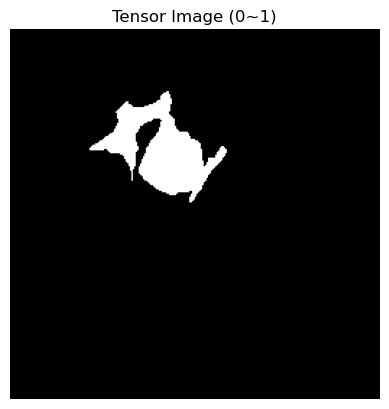

In [ ]:
# print one mask tensor to check

np_img = mask_tensors[4].permute(1, 2, 0).numpy()  

plt.imshow(np_img)
plt.axis('off')
plt.title("Tensor Image (0~1)")
plt.show()

In [6]:
# data split: 80/10/10
train_img, test_img, train_mask, test_mask = train_test_split(image_tensors, mask_tensors, test_size = 0.1)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1)

In [ ]:
# Create dataset and dataloader
train_dataset = TensorDataset(train_img, train_mask)
val_dataset = TensorDataset(val_img, val_mask)
test_dataset = TensorDataset(test_img, test_mask)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 3. Model Design

In this section, we will design a UNet architecture to show the usage of this data for image segmentation predictive modeling. Here we can see the process of designing a model architecture using Pytorch, along with a custom loss function that will result in optimal performance for this model. Finally, we will train the model over 200 epochs using patience, a concept that we will elaborate on below.

In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu, sigmoid
from datetime import datetime

### 3-1. Creating the Model

First, we will construct the model. Let's take a closer look at how a UNet works.

A UNet is an image segmentation framework that makes predictions in a two step Encoding-Decoding process.

At each encoding step, the tensor will be downsampled and the number of channels will increased. This is done by using two convolution layers followed by a max-pooling layer.
Max-pooling is a process that downscales a 2D tensor by taking the maximum value within a 2x2 window as the representative value for that group.

Next, the tensor will be upsampled in an inverted process to encoding through several steps of decoding. Each docoder step starts by using transposed convolution followed by two convolution layers. The number of channels gradually decreases as the image reverts to it's original shape. 

To complete a forward pass during training, the Encoder-Decoder steps must be combined in a way that preserves the information of the original image. To do this, we concatonate the the encoder outputs to their corresponfding decoder counterparts after transposed convolution occurs. 

Through this process, a final output image is produced as the predicted mask for the MRI brain scan. A sigmoid activation is applied to this output to ensure each predicted pixel value is between 0-1, making binary classification simple.

In [ ]:
class UNet(nn.Module):
    def __init__(self, kernel_size, stride, padding):
        super().__init__()

        # First we need to make the Encoder
        # There are 5 Encoder modules, each consisting of two convolution encoder layers to 
        # increase the number of channels and a maxpooling layer to downsample
        self.e11 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e12 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e22 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e32 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e42 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e52 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding)


        # Next, we will make the Decoder 
        # There will be 4 decoder modules, each upsampling using transposed convolution
        # followed by two convolution decoder layers to recover the original image shape
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d12 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d22 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d32 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d42 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)


        # Finally, we use a final output layer to create a single channel prediction
        self.output = nn.Conv2d(32, 1, kernel_size=1)


    # Now we create a forward pass pipeline for input processing through the model
    def forward(self, x):
        # Each encoder layer uses ReLU activation
        e11 = relu(self.e11(x))
        e12 = relu(self.e12(e11))
        maxpool1 = self.maxpool1(e12)

        e21 = relu(self.e21(maxpool1))
        e22 = relu(self.e22(e21))
        maxpool2 = self.maxpool2(e22)

        e31 = relu(self.e31(maxpool2))
        e32 = relu(self.e32(e31))
        maxpool3 = self.maxpool3(e32)

        e41 = relu(self.e41(maxpool3))
        e42 = relu(self.e42(e41))
        maxpool4 = self.maxpool4(e42)

        e51 = relu(self.e51(maxpool4))
        e52 = relu(self.e52(e51))

        # At each decoder level, we must concatenate corresponding encoder level outputs to retain image information
        upconv1 = self.upconv1(e52)
        upconv1 = torch.cat([upconv1, e42], dim=1)
        d11 = self.d11(upconv1)
        d12 = self.d12(d11)

        upconv2 = self.upconv2(e42)
        upconv2 = torch.cat([upconv2, e32], dim=1)
        d21 = self.d21(upconv2)
        d22 = self.d22(d21)

        upconv3 = self.upconv3(d22)
        upconv3 = torch.cat([upconv3, e22], dim=1)
        d31 = self.d31(upconv3)
        d32 = self.d32(d31)

        upconv4 = self.upconv4(d32)
        upconv4 = torch.cat([upconv4, e12], dim=1)
        d41 = self.d41(upconv4)
        d42 = self.d42(d41)

        # Use sigmoid activation on the output layers
        out = self.output(d42)
        out = sigmoid(out)

        return out

### 3-2. Hyperparameter tuning

Let's define some hyperparameters for the models architecture and training. These hyperparameters are tuned to obtain optimal performance. Try changing some values and see how the model's performance changes.
Let's take a closer look at some of these hyperparameters:
- Kernel Size - This is how big the "sliding window" of the UNet's convolution layers is. A size of 3 will result in a 3x3xc kernel that takes a weighted average of the corresponding pixel values.
- Stride - This is how large the step-size of the kernel is. A stride of 1 means the kernel will move 1 pixel at a time left-to-right and top-to-bottom.
- Padding - This is how many pixels we will zero-pad the image with. Having padding allows us to avoid losing information at the boundaries and control image dimensionality shrinkage during convolution.
- Number of Epochs - This will control the maximum number of training iterations (over ALL training data) will be completed to find the best possible model parameters.
- Patience - This allows us to perform early-stopping if the model fails to improve over a specified number of epochs. 
- BCE Weight - This will be used to adjust the weight of Dice Loss and BCE Loss in the loss function. The value must remain between 0-1, with 1 being equivalent to exclusively BCE Loss and 0 exclusively Dice Loss.

In [ ]:
# parameter setup
folder_path = './models'

kernel_size = 3
stride = 1
padding = 1

num_epochs = 200
patience = 50

bce_weight = 0.5 # Coefficient for Binary Cross Entropy loss in loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3-3. Loss Function

Binary Cross Entropy Loss is a common loss function used for binary classification. In the case of the MRI brain scan image dataset, BCE loss is allows us to train the model for predicting individual pixels as 0 or 1, penalizing incorrect predictions.

Although BCE loss is useful, it does have limitations for this dataset, especially considering class imbalances with most pixels being 0 (no tumor) in these images. To account for this, we will design a custom loss function that incorperates the Dice Coefficient into the loss, a method that lets us account for the overlap between predicted masks and actual masks using the intersection of the two. 

To do this, we need to create a class that calculates the Dice Loss of predicted and actual masks. Next, we define a BCEDiceLoss class that combines the two methods into a single loss function, weighing each using a weigthed some. This weight coeficcient can be tuned as a hyperparameter to increase the influence of one loss function on the results.

In [ ]:
# Loss function setup
# Create a class for Dice Loss
class DiceLoss(nn.Module):
    # Initializing the loss function will require a smoothing parameter to prevent division by zero 
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    # The loss function is defined in a forward pass as 2*(intersection)/(pred + true)
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

# Create a class for BCE Loss
class BCEDiceLoss(nn.Module):
    # Initializing the loss function will require a BCE weight parameter to determine the weigth of each loss 
    def __init__(self, bce_weight=0.5):
        super().__init__()
        # Declare both loss functions
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    # The loss function is defined by taking the weighted sum of BCE Loss and Dice Loss
    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return bce_weight * bce_loss + (1-bce_weight) * dice_loss
        

### 3-4. Model Training

First, we need to create the model.

In [ ]:
# Create an instance of UNet
model = UNet(kernel_size, stride, padding)
model.to(device)

UNet(
  (e11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(256, 512, kernel

Now we can start the training process. Here, we first define some variables that will be used for training and saving the best instance of the model. The loss criterion is set to BCEDiceLoss and the optimizer is Adam optimization.

For each epoch, we train in batches of size 64, increasing the overall efficiency of the process. During each batch, we gather the MRI scans and their corresponding binary masks for the model to make predictions. After predictions are made, the loss will be calculated by comparing the predicted masks to the actual masks. The results of this loss will be used iteratively to better optimize the model's parameters for performing this task.

Next, we will validate the model using data from the validation dataset. No optimization is carried out during this proces, but the loss calculated during this process will be used to determine the best performing model across all epochs.
If the average validation loss improves from the best overall validation loss, we save the model's state as the best performing model.

Now let's discuss the patience hyperparameter we mentioned previosly. As stated, patience is used for early stopping. This allows us to stop training before all training iterations are complete in the case that the model fails to show improvement. For example, if the patience is set to 50 and we train for 200 epochs, the training process will end if we see no model improvement over a 50 epoch period. So, the training process will end before 200 epochs as we deem no improvement within 50 epochs to be sufficient proof that further iterations are unnecessary and are unlikely to yield desirable results.

In [ ]:
# Train UNET
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss(bce_weight=0.5)

# Train over the entire dataset every epoch
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Train in batches to improve efficiency
    for batch in trainloader:
        optimizer.zero_grad(set_to_none=True)
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        # Make predictions on the training images
        pred_mask = model(images)

        # Calculate the loss and take an optimization step based on the predictions
        loss = 0
        loss += criterion(pred_mask, true_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Average the loss over all batches
    avg_loss = total_loss / len(trainloader)


    # Now, validate the model
    model.eval()
    val_loss = 0

    # Gradients are not used as validation is used to find the best model without further optimization
    with torch.no_grad():
        # Validate in batches
        for batch in valloader:
            images, true_mask = batch
            images = images.to(device)
            true_mask = true_mask.to(device)
            
            # Make predictions on the validation images
            pred_mask = model(images)

            # Calculate the loss
            loss = 0
            loss += criterion(pred_mask, true_mask)
            val_loss += loss.item()
    
    # Average the validation loss over all batches
    avg_val_loss = val_loss / len(valloader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    # Best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"{folder_path}/best_model_{str(best_val_loss)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

        
            

Epoch 1/200 - Train Loss: 0.6611 - Validation Loss: 0.5313
Validation loss improved. Best model updated.
Epoch 2/200 - Train Loss: 0.5176 - Validation Loss: 0.4813
Validation loss improved. Best model updated.
Epoch 3/200 - Train Loss: 0.4269 - Validation Loss: 0.3177
Validation loss improved. Best model updated.
Epoch 4/200 - Train Loss: 0.3132 - Validation Loss: 0.2455
Validation loss improved. Best model updated.
Epoch 5/200 - Train Loss: 0.2854 - Validation Loss: 0.2410
Validation loss improved. Best model updated.
Epoch 6/200 - Train Loss: 0.2669 - Validation Loss: 0.2173
Validation loss improved. Best model updated.
Epoch 7/200 - Train Loss: 0.2644 - Validation Loss: 0.2098
Validation loss improved. Best model updated.
Epoch 8/200 - Train Loss: 0.2614 - Validation Loss: 0.2108
No improvement for 1 epoch(s).
Epoch 9/200 - Train Loss: 0.2391 - Validation Loss: 0.2246
No improvement for 2 epoch(s).
Epoch 10/200 - Train Loss: 0.2403 - Validation Loss: 0.2078
Validation loss improved.

In [14]:
# save the best model
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

Best model saved to ./models/best_model_0.06858640909194946_20250420_121526.pth


# 4. Results

This section analyzes the performance of the model in terms of Dice coefficient, IoU, and Recall. Note that we achieve notably high scores across these metrics, and visual inspection of the predicted masks show a strong resemblance to the ground truth masks, further confirming the effectiveness of the UNET approach.

### 4-1. Model Testing

Now that we have a fully trained and optimized model, let's see the performance on unseen data. This proces involves iterating over all batches in the test dataset and making mask predictions that will allow us to compare with actual masks to see how our model performs. 

This process differs from validation int hat validation data is still used to optimize the model during training. On the other hand, test set data is used to analyze the fully trained, finalized model's predictive performance.

The metrics we will use to evaluate this model are as follows:
- Dice Coefficient - We have previously described the use of the Dice Coefficient. It allows us to measure the overlapping pixels between the predicteed masks and the actual masks by multiplying the intersection of them by two and dividing by their sum.
- IoU - Intersection over Union is a prominent image segmentation metric. IoU is simal to the Dice Coefficient, measuring the overlapping area by taking the intersection of the two masks and dividing by their union.
- Recall - Recall score shows the model's performance with regards to the number of false negatives. With brain tumors, we care much more about false negatives than false positives as a false negative could mean late discovery or the death of a patient.

In [ ]:
# test UNET
model.load_state_dict(torch.load(best_model_filename, map_location=device))
model.eval()

# Create arrays to store all predictions and all ground truth masks
pred_mask_all, true_mask_all = [], []

with torch.no_grad():
    for batch in testloader:
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        # Make test predictions
        pred_mask = model(images)

        pred_mask_all.append(pred_mask.cpu().numpy())
        true_mask_all.append(true_mask.cpu().numpy())

    # Concatenate all batches into a single array for performance                        
    preds = np.concatenate(pred_mask_all, axis=0)   
    trues = np.concatenate(true_mask_all, axis=0)        

    # Squeeze from 4 dimensions into 3 since we use only one channel
    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)

    # Binarize predictions
    preds  = (preds > 0.5).astype(np.uint8)
    trues  = trues.astype(np.uint8)

    preds = preds.flatten()
    trues = trues.flatten()

    # Calculate TP, FP, FN for evaluation metrics
    tp = np.logical_and(preds==1, trues==1).sum()
    fp = np.logical_and(preds==1, trues==0).sum()
    fn = np.logical_and(preds==0, trues==1).sum()

    # Calculate evaluation metrics
    smooth = 1e-6
    dice = (2*tp + smooth) / (2*tp + fp + fn + smooth)
    iou  = (tp + smooth)   / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

                             
    # Dice coefficient
    # IoU (Jaccard Index)
    # Recall - We care a lot about false negatives
    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
        }
    
    print("\n **Test Results:**")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")



 **Test Results:**
Dice Coefficient: 0.8907
IoU: 0.8029
Recall: 0.9007


### 4-2. Visualization

Now that the model has been fully trained and tested, it's time to visualize the results.

First, let's take a look at the predicted masks compared to the actual masks alongside the brain scan.

In [ ]:
# Let's see the visualized results!
def show_brain_masks(images: torch.Tensor,
                     true_masks: torch.Tensor,
                     pred_masks: torch.Tensor,
                     n_rows: int = 5):
    """
    images:     torch.Tensor of shape (N, C, H, W) or (N, H, W, C), pixel value range [0,1] or [0,255]
    true_masks: torch.Tensor of shape (N, 1, H, W) or (N, H, W), 0/1 or 0~255
    pred_masks: torch.Tensor of same shape as true_masks
    n_rows:     sample number to print (default: 5)
    """
    # 1. pick the masks that has white part (which actually has a tumor)
    tm = true_masks
    if tm.dim() == 4 and tm.shape[1] == 1:
        tm = tm.squeeze(1)
    has_white = (tm > 0).view(tm.shape[0], -1).any(dim=1)
    idxs = torch.nonzero(has_white, as_tuple=False).flatten()
    if idxs.numel() == 0:
        print("There are no masks with white part")
        return

    # 2. select 5 samples
    idxs = idxs[5:5+n_rows]

    # 3. Plot
    fig, axes = plt.subplots(n_rows, 3, figsize=(9, 3 * n_rows))
    for row, idx in enumerate(idxs):
        # brain MRI
        img = images[idx]
        # (C,H,W) → (H,W,C)
        if img.dim() == 3 and img.shape[0] in (1,3):
            img = img.permute(1,2,0)
        img_np = img.detach().cpu().numpy()
        # [0,255] → [0,1]
        if img_np.max() > 1.0:
            img_np = img_np / 255.0

        ax = axes[row, 0]
        # if it's grayscale image
        if img_np.ndim == 2 or img_np.shape[2] == 1:
            ax.imshow(img_np.squeeze(), cmap="gray")
        else:
            ax.imshow(img_np)
        ax.set_title("Brain MRI")
        ax.axis("off")

        # ground truth
        tm_i = tm[idx].detach().cpu().numpy()
        ax = axes[row, 1]
        ax.imshow(tm_i, cmap="gray")
        ax.set_title("ground truth")
        ax.axis("off")

        # predicted mask
        pm = pred_masks[idx]
        if pm.dim() == 3 and pm.shape[0] == 1:
            pm = pm.squeeze(0)
        pm_np = pm.detach().cpu().numpy()
        ax = axes[row, 2]
        ax.imshow(pm_np, cmap="gray")
        ax.set_title("prediction")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

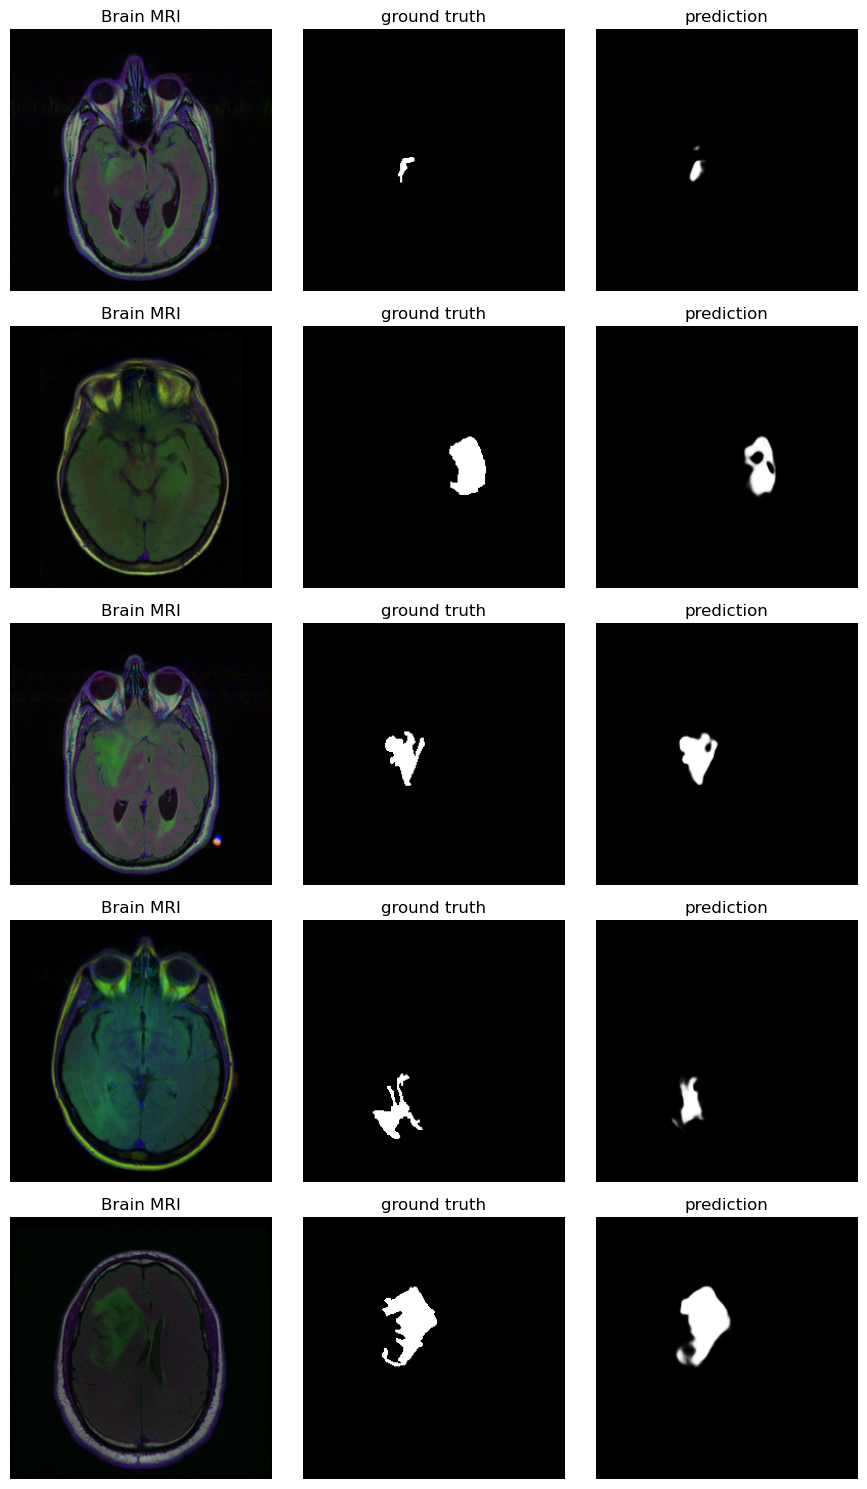

In [ ]:
test_batch, true_mask_batch = next(iter(testloader))
test_batch = test_batch.to(device)
pred_mask = model(test_batch)
show_brain_masks(test_batch, true_mask_batch, pred_mask)

Great, now we have seen the masks compared to the actual tumor masks. We can see that the predictions are very similar to the ground truths, but it may be difficult to use these results in isolation. 

When looking at an image from an MRI that has been passed through this model, it would be helpful to see how the mask looks on the actual brain scan rather than as white and black pixels. 

Here, we'll visualize some of these masks placed on top of their corresponding brain scans, showing how the model's results can be used to identify regions of concern on real brain scans.

In [ ]:
# We can also check the overlapping part of brain and predicted mask
def show_images(images: torch.Tensor,
                masks: torch.Tensor,
                n_images: int = 25):
    """
    images: torch.Tensor of shape (N, C, H, W) or (N, H, W, C), values in [0,1] or [0,255]
    masks:  torch.Tensor of shape (N, 1, H, W) or (N, H, W), values 0/1 or 0~255
    n_images: number of samples to show (<= N), default is 25
    """

    n = min(n_images, images.shape[0], masks.shape[0])

    plt.figure(figsize=(12, 12))
    for i in range(n):
        # image tensor to numpy
        img = images[i]
        if img.dim() == 3 and img.shape[0] in (1,3):  
            # (C, H, W) → (H, W, C)
            img = img.permute(1, 2, 0)
        img_np = img.detach().cpu().numpy()

        # set to range [0,1]
        if img_np.max() > 1.0:
            img_np = img_np / 255.0

        # mask tensor to numpy
        m = masks[i]
        if m.dim() == 3 and m.shape[0] == 1:  
            m = m.squeeze(0)  # (1, H, W) → (H, W)
        mask_np = m.detach().cpu().numpy()

        # set to range [0,1]
        if mask_np.max() > 1.0:
            mask_np = mask_np / mask_np.max()

        # print
        ax = plt.subplot(5, 5, i + 1)
        ax.imshow(img_np)
        ax.imshow(mask_np, cmap='jet', alpha=0.4)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


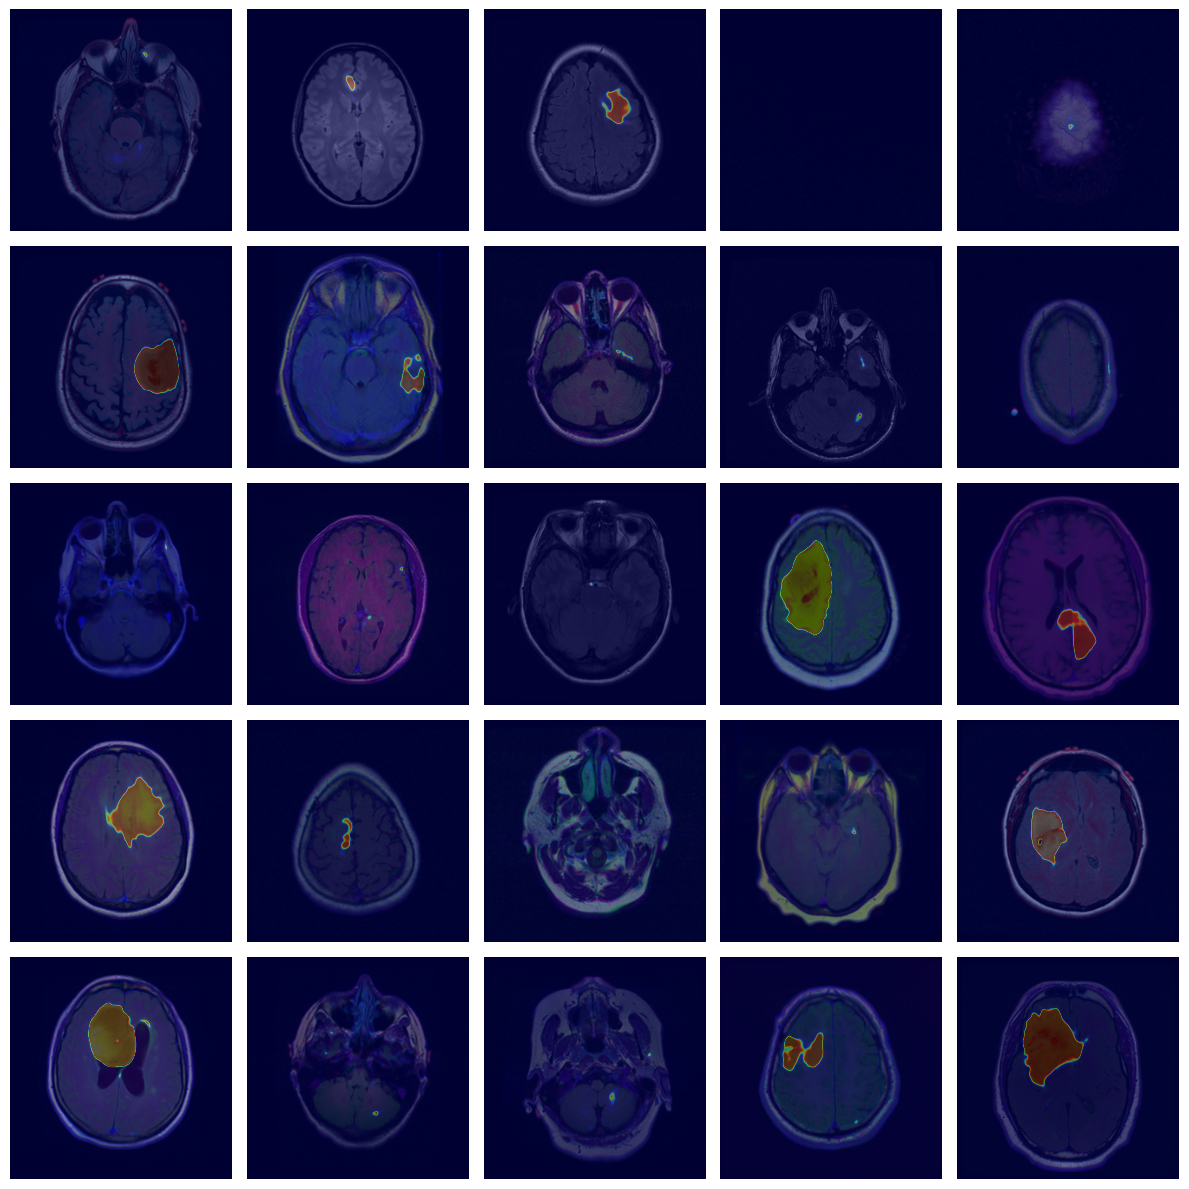

In [ ]:
test_batch, true_mask_batch = next(iter(testloader))
test_batch = test_batch.to(device)
pred_mask = model(test_batch)
show_images(test_batch, pred_mask)

# 5. Discussion and Conclusions

Our UNet outperformed the state-of-the-art models in our experiments, demonstrating strong segmentation performance on the given dataset. However, its effectiveness did not generalize well to other datasets, indicating limitations in its adaptability. As future work, we aim to develop a more generalizable model that can maintain high performance across diverse datasets.

The TransUNet and SwinUNETR can be analyzed in the `additional_models.ipynb` notebook.